In [2]:
using LinearAlgebra
using LaTeXStrings
#using Plots
#gr()
using FFTW # for Fourier transforms
using Polynomials

<h2>Numerical</h2>

In [3]:
function bathHamiltonian(N,J,periodic=true)
    H = zeros(N,N)
    for n in 1:N-1
        H[n+1,n] = -J
        H[n,n+1] = -J
    end
    if periodic
        H[1,N] = -J
        H[N,1] = -J
    end
    return H
end

bathHamiltonian (generic function with 2 methods)

In [4]:
function translation(N)
    # translation operator in real space
    T = zeros(N,N)
    T[1,N] = 1.0 
    for n in 1:N-1 
        T[n+1,n] = 1.0
    end  
    return T
end

translation (generic function with 1 method)

In [5]:
function matched_eigen(T)
    # for block diagonal matrix T: return eigendecomposition in the same order as the original basis
    evals, evecs = eigen(T) # unordered spectrum

    for i in 1:length(evals)
        maxindex = argmax(abs.(evecs[i,i:end])) + (i - 1) # scan row for first maximum value (ignoring the first i-1 ordered columns)
        # swap ith column for column with maximum value (swap eigenvalues too)
        evecs[:,[i,maxindex]] = evecs[:,[maxindex,i]]
        evals[[i,maxindex]] = evals[[maxindex,i]]
    end

    return evals, evecs
end

matched_eigen (generic function with 1 method)

In [6]:
function fullHamiltonian(H_bath,δ,g)
    N = length(H_bath[1,:])
    H = zeros(N+1,N+1) # one excitation subspace
    # H_B
    H[2:end,2:end] = H_bath # bath part in k basis |k><k'|
    # H_A
    H[1,1] = δ # |e><e|
    # H_I
    H[1,2:end] = ones(N) .* g ./ √N # atom absorbs a photon from bath |e,vac><g,k|
    H[2:end,1] = ones(N) .* g ./ √N # atom emits a photon into the bath |g,k><e,vac|
    return H
end

fullHamiltonian (generic function with 1 method)

In [8]:
function evolveState(ψ_0,H_full,times)
    fidelity = zeros(length(times)) # evolution of fidelity to initial state
    bath_distribution = zeros(length(ψ_0)-1, length(times)) # evolution of bath probability distribution
    for (i,t) in enumerate(times)
        ψ_t_recip = exp(-1im * H * t) * ψ_0  # Schrodinger's equation, H and ψ in k space
        fidelity[i] = abs2(adjoint(ψ_0) * ψ_t_recip) # Born's rule
        ψ_t_real = recipToReal * ψ_t_recip[2:end] # rotate into real space
        bath_distribution[:,i] = abs2.(ψ_t_real) # each column is a probability distribution
    end
    return fidelity, bath_distribution
end

evolveState (generic function with 1 method)

In [18]:
# sample script
N,J,δ,g = 100, 1.0, 0.5, 0.1

# bath hamiltonian and spectrum
H_bath = bathHamiltonian(N,J)
evals_Hb, evecs_Hb = eigen(H_bath) # H_b = evecs_Hb x Λ x evecs_Hb†

T = translation(N) # translation matrix in real space
T_rot = adjoint(evecs_Hb) * T * evecs_Hb # translation matrix in the bath hamiltonian eigenbasis
evals_T, evecs_T = matched_eigen(T_rot) # translation matrix spectrum corresponding to the bath hamiltonian spectrum
recipToReal = evecs_Hb * evecs_T # sends vectors in k basis to vectors in real basis
k = imag(log.(evals_T)) # λ = e^(ik) , T is unitary so |λ|=1 and T is N indempotent so λ are N_th roots of unity, i.e. k = 2π/N * n            

H = fullHamiltonian(Diagonal(evals_Hb),δ,g)
evals_H, evecs_H = eigen(H)

times = collect(0:0.1:10) 
ψ_0 = zeros(N+1) # bath is in k space
ψ_0[1] = 1.0 # excited QE, empty bath
fidelity, bath_evolution = evolveState(ψ_0,H,times)

([1.0, 0.9999001905717918, 0.9996030366403195, 0.9991152682188238, 0.998447796561418, 0.9976152722576355, 0.996635498097671, 0.9955287260640582, 0.9943168732403892, 0.9930226949112274  …  0.910768684831264, 0.9097941971173799, 0.9088219457660889, 0.9078517522190288, 0.9068827948611898, 0.9059137376693588, 0.9049428996306631, 0.9039684520208326, 0.902988628914366, 0.9020019355584434], [0.0 2.9339223197519443e-7 … 0.001536265887377405 0.0014842230585255375; 0.0 9.168941075659407e-10 … 0.0019768490230624826 0.0020585834273433314; … ; 0.0 3.4399958633965317e-6 … 0.0017805901992566596 0.0019102508133896608; 0.0 4.3511956312758484e-8 … 0.0008722363334207746 0.0008815436841396282])

<h3>Bath (& translation) egienstates and density of states</h3>

<h5>Energy eigenstates</h5>

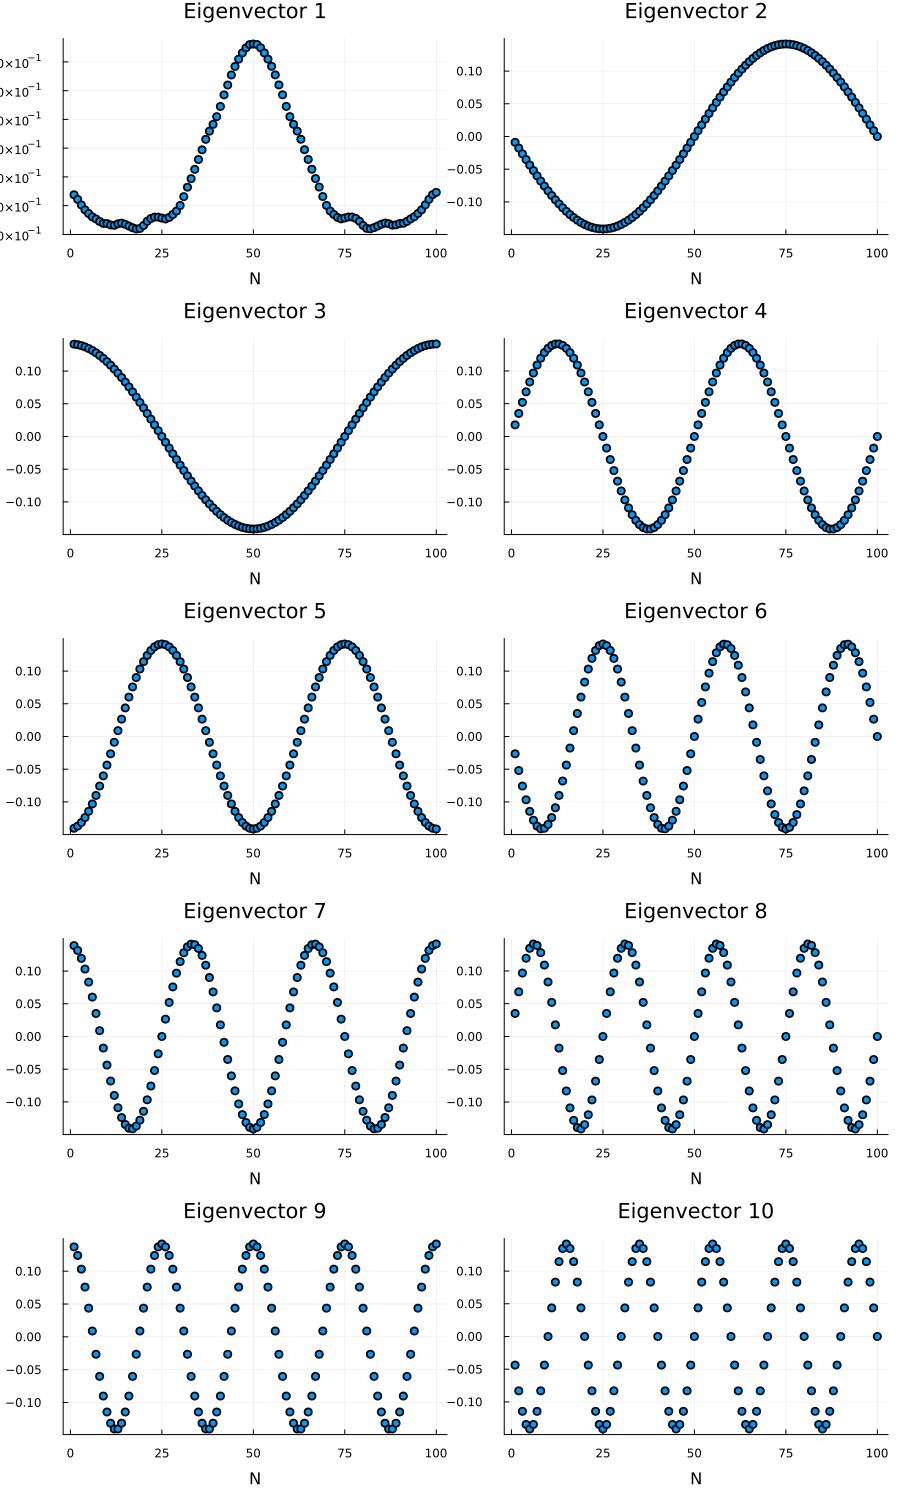

GKS: Possible loss of precision in routine SET_WINDOW


In [13]:
using Plots
# real space eigenvectors
fig = scatter(layout=(5, 2), size=(300*3, 300*5))

for i in 1:10
    scatter!(collect(1:N), evecs[:,i], title="Eigenvector $(i)", xlab="N", ylab="", legend=false, subplot=i)
end

display(fig)

<h5>Wavenumber via translation operator</h5>

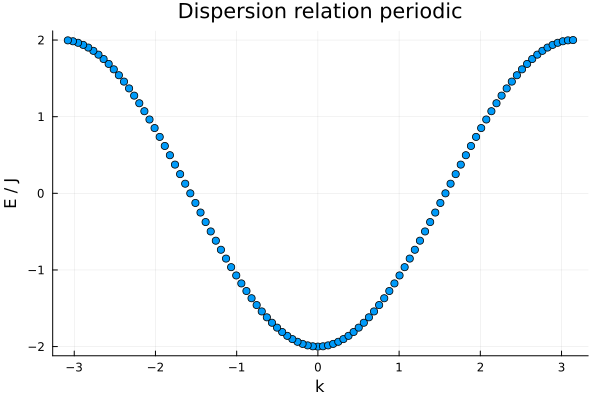

In [ ]:
# plot dispersion relation
using Plots
scatter(k, evals_Hb, title="Dispersion relation periodic", xlab="k", ylab="E / J", legend=false)

<h5>Wavenumber via fourier transform</h5>

In [ ]:
# rotate H_bath eigenspace to try to go from cosines and sines to exponentials
evecs_new = Complex.(evecs)
counter = 0
evals = round.(evals, digits=8)

for n in 1:2:100
    i,j... = findall(==(evals[n]), evals) # check for degenerate states and record their indeces
    if isempty(j) == true
        continue
    else
        counter += 1
        j = j[1]
        # old basis
        cos = evecs[:,i]
        sin = evecs[:,j]
        # new basis
        evecs_new[:,i] = cos .+ 1im.*sin
        evecs_new[:,j] = cos .- 1im.*sin
    end
end

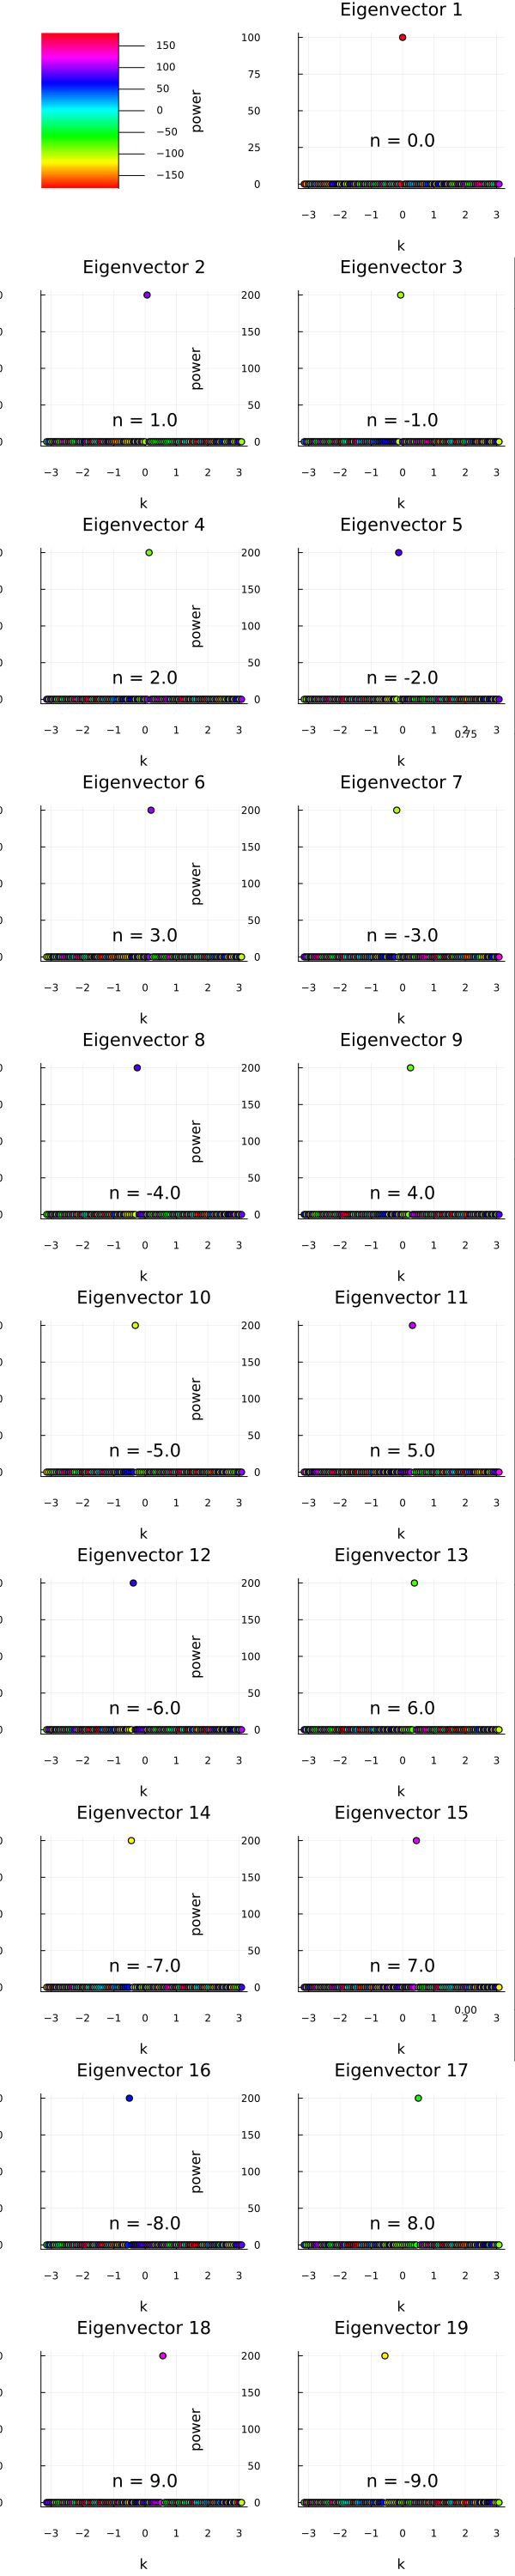

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [ ]:
# reciprocal space eigenvectors
fig = scatter(layout=(10, 2), size=(300*2, 300*10))
peaks = zeros(Int, N) # store positive peak index of each eigenvector
n = zeros(N) # multiple of fundamental freq (2π/N)

# perform FFT, note that this algorithm ASSUMES periodic bcs
for i in 2:20
    evecs_fft = fftshift(fft(evecs_new[:,i-1])) # match with negative freqs
    pwr_spectrum = abs2.(evecs_fft)
    phase = angle.(evecs_fft) .* 180 ./ π
    peaks_i = findall(>(40), pwr_spectrum) # indeces of all peaks
    peaks[i-1] = peaks_i[end]              
    n[i-1] = round(k[peaks[i-1]] * N / 2π)
    annotate!(fig[i],(0,30, "n = $(n[i-1])"))
    if length(peaks_i) > 1
        phase_diff = mod(trunc(phase[peaks_i[end]] - phase[peaks_i[1]]), 360)
        scatter!(k, pwr_spectrum, marker_z = phase, subplot=i, title="Eigenvector $(i-1)", xlab="k", ylab="power", color=:hsv, colorbar= false, legend=false)
        annotate!(fig[i],(0,40, "∆φ = $(phase_diff)"))
    else
        scatter!(k, pwr_spectrum, marker_z = phase, subplot=i, title="Eigenvector $(i-1)", xlab="k", ylab="power", color=:hsv, colorbar= false, legend=false)
    end
end

scatter!([NaN], [NaN],marker_z = [0.0],color = :hsv,clim = (-180, 180),colorbar = true,subplot = 1,colorbar_titlefont = font(8))

#savefig("Rotated_Eigenvectors_spectrum.png")
display(fig)

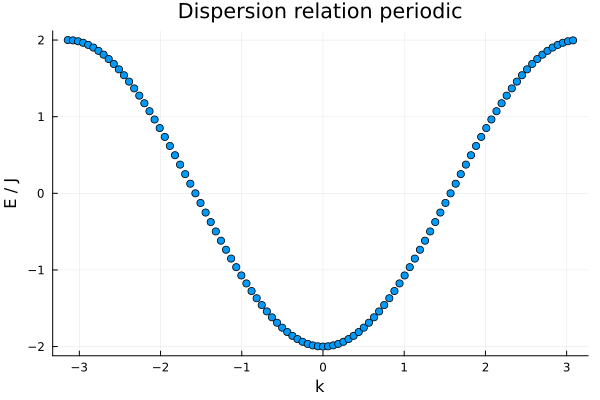

In [ ]:
# order eigenvectors by increasing k
for i in 1:N
    evecs_fft = fftshift(fft(evecs_new[:,i])) # match with negative freqs
    pwr_spectrum = abs2.(evecs_fft)
    peaks_i = findall(>(30),pwr_spectrum) # indeces of all peaks
    peaks[i] = peaks_i[end]               # index of positive peak
    n[i] = k[peaks[i]] * N / 2π
end

sort = sortperm(n)             # index permutation that would sort n in ascending order
k_evals = (2π / N) .* n[sort]  # extracted ks in ascending order
evals = evals[sort]
scatter(k_evals, evals, title="Dispersion relation periodic", xlab="k", ylab="E / J", legend=false)
#savefig("Dispersion_ring.png")

<h5>Density of states</h5>

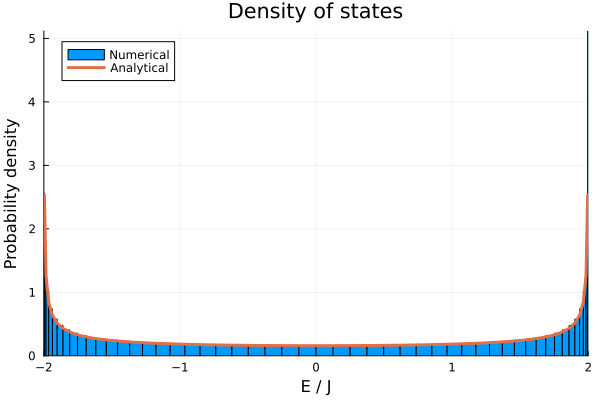

In [20]:
densityOfStates(E) = (π * √(4 * J^2 - E^2))^(-1) # analytical expression
D_E = densityOfStates.(evals_Hb[2:end-1])
edges = unique(round.(evals_Hb, digits=8)) # space as it is spaced in the spectrum of H

using Plots
histogram(round.(evals_Hb, digits=8), bins = edges, xlim = (-2, 2),title="Density of states", xlab="E / J", ylab="Probability density", normalize= true, label="Numerical")
plot!(evals_Hb[2:end-1], D_E, lw=3, label="Analytical")

<h3>Full Hamiltonian evolution</h3>

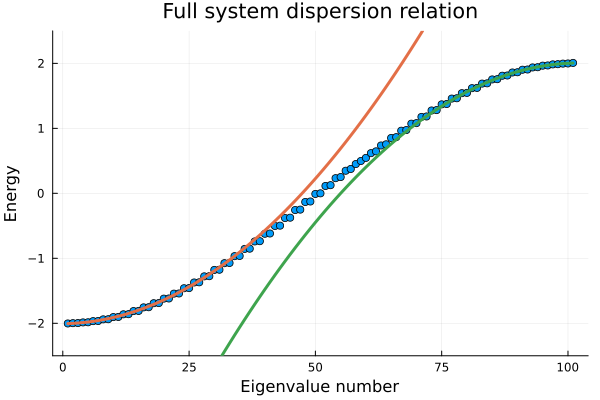

In [24]:
# plot dispersion relation
using Plots
x = collect(1:length(evals_H))
p1_fit = fit(x[1:25], evals_H[1:25], 2)
p2_fit = fit(x[end-25:end], evals_H[end-25:end], 2)
scatter(1:length(evals_H) , evals_H, title="Full system dispersion relation", xlab="Eigenvalue number", ylab="Energy", legend=false)
plot!(x, p1_fit.(x), ylim=(-2.5,2.5), label="Parabola 1", lw=3)
plot!(x, p2_fit.(x), ylim=(-2.5,2.5), label="Parabola 2", lw=3)

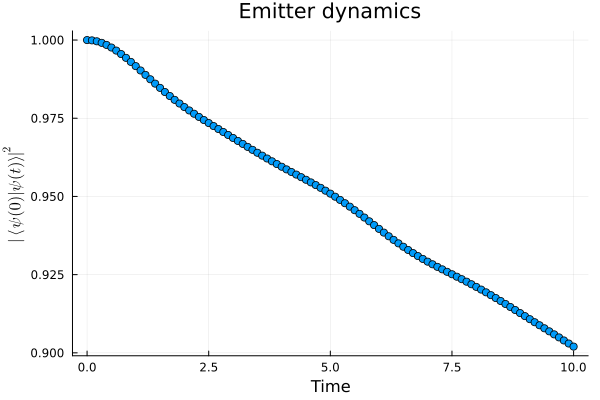

In [19]:
# plot evolution
using Plots
scatter(times,fidelity, title="Emitter dynamics", xlab="Time", ylab=L"|\langle \psi(0) | \psi(t) \rangle |^2", legend=false)

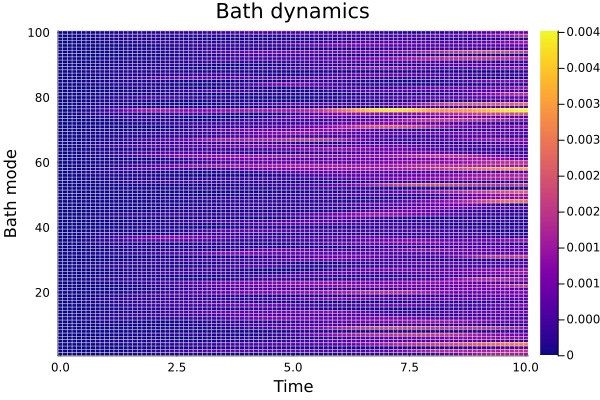

In [20]:
# plot evolution of bath
using Plots

function pixelated_heatmap(data; xlabel="", ylabel="", title="", color=:plasma, gridcolor=:white, lw=0.5)
    nrows, ncols = size(data)
    heatmap(data, 
            interpolate = false,       # <-- disables color blending
            xlabel = xlabel,
            ylabel = ylabel,
            color = color,
            title = title)
    vline!(0.5:1:(ncols+0.5), color=gridcolor, lw=lw, label="")
    hline!(0.5:1:(nrows+0.5), color=gridcolor, lw=lw, label="")
end

pixelated_heatmap(bath_evolution, xlabel="Time", ylabel="Bath mode", title="Bath dynamics")
col_idxs = Int.(round.(range(1,size(bath_evolution,2), length=5)))
xticks!(col_idxs, string.(times[col_idxs]))

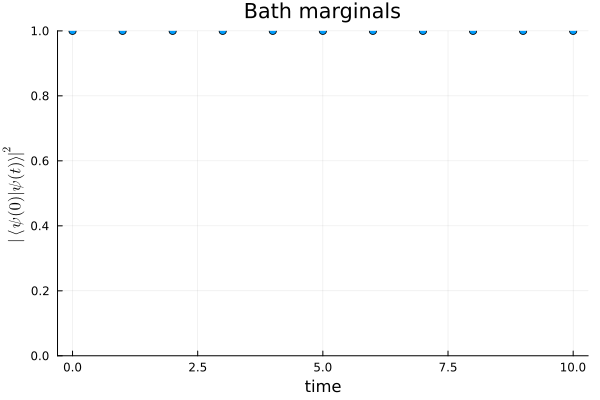

In [66]:
marginals = sum(bath_evolution; dims=1)[1,:] # sum all rows elementwise
scatter(times,marginals + fidelity, title="Bath marginals", xlab="time", ylab=L"|\langle \psi(0) | \psi(t) \rangle |^2", ylim=(0,1),legend=false)
